In [1]:
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


######################################################
################### TENSORBOARD ######################
######################################################

writer = SummaryWriter('runs/VN_Money')

######################################################

cuda


In [2]:
transform = transforms.Compose([
        transforms.RandomRotation(10),      
        transforms.RandomHorizontalFlip(),  
        transforms.Resize((64,64)),             
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
])

class MoneyDataset(torch.utils.data.Dataset):
    def __init__(self, root, transform = None):
        self.data = datasets.ImageFolder(root, transform = transform)
        self.classes = self.data.classes
        self.num_classes = len(self.classes)
    def __getitem__(self, index):
        img, label = self.data[index]
        one_hot_label = F.one_hot(torch.tensor(label), num_classes=self.num_classes).float()
        return img, one_hot_label   
    
    def __len__(self):
            return len(self.data)
        
x_train = MoneyDataset( root=("/kaggle/input/vn-money/Money/Train"), transform = transform)
x_val = MoneyDataset(root = ('/kaggle/input/vn-money/Money/Val'), transform = transform)

In [3]:
class_name = x_train.classes
print("Tổng class: ",len(class_name))
print("Tên các loại: ",class_name)

batch = 128
epochs = 80
learning_rate = 3*1e-3
weight_decay = 1e-4

train_loader = DataLoader(x_train, batch_size = batch, shuffle = True)
val_loader = DataLoader(x_val, batch_size = batch, shuffle = True)


examples = iter(val_loader)
example_data, example_targets = next(examples)

######################################################
################### TENSORBOARD ######################
######################################################

img_grid = torchvision.utils.make_grid(example_data)
writer.add_image("Money",img_grid)
writer.close()

######################################################

Tổng class:  6
Tên các loại:  ['100k', '10k', '20k', '500k', '50k', '5k']


In [4]:
class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()
    self.maxpool = nn.MaxPool2d(kernel_size = 2, stride = 2)
    self.conv1 = nn.Conv2d(3,32,3,stride = 1, padding = 2)
    self.conv2 = nn.Conv2d(32,64,3,stride = 1, padding = 1)
    self.conv3 = nn.Conv2d(64,128,3,stride = 1, padding = 1)
    self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
    self.dropout = nn.Dropout(p = 0.1)
    self.fc1 = nn.Linear(7*7*128, 124)
    self.fc2 = nn.Linear(124,32)
    self.fc3 = nn.Linear(32, 6)
    
  def forward(self, x):
    x = self.maxpool(F.leaky_relu(self.conv1(x)))
    x = self.maxpool(F.leaky_relu(self.conv2(x)))
    x = self.maxpool(F.leaky_relu(self.conv3(x)))
    x = self.avgpool(x)
    x = x.view(-1, 7*7*128)
    x = self.dropout(F.leaky_relu(self.fc1(x)))
    x = self.dropout(F.leaky_relu(self.fc2(x)))
    x = self.fc3(x)

    return x

model = CNN().to(device)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, weight_decay = weight_decay)

######################################################
################### TENSORBOARD ######################
######################################################

writer.add_graph(model, example_data.to(device))
writer.close()

######################################################

In [5]:
from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: 
            continue
        param = parameter.numel()
        table.add_row([name, param])
        total_params+=param
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params

count_parameters(model)

+--------------+------------+
|   Modules    | Parameters |
+--------------+------------+
| conv1.weight |    864     |
|  conv1.bias  |     32     |
| conv2.weight |   18432    |
|  conv2.bias  |     64     |
| conv3.weight |   73728    |
|  conv3.bias  |    128     |
|  fc1.weight  |   777728   |
|   fc1.bias   |    124     |
|  fc2.weight  |    3968    |
|   fc2.bias   |     32     |
|  fc3.weight  |    192     |
|   fc3.bias   |     6      |
+--------------+------------+
Total Trainable Params: 875298


875298

In [6]:
n_total_steps = len(train_loader)

run_loss = 0.0
run_acc = 0.0
for epoch in range(epochs):
    for i, (images, labels) in enumerate(tqdm(train_loader)):
        images = images.reshape(-1,3,64,64).to(device)
        labels = labels.to(device)
        _, labels = torch.max(labels.data, 1)

        outputs = model(images)

        loss = criterion(outputs,labels)
        
        run_loss +=loss.item() #for tensorboard
        _,pred = torch.max(outputs.data, 1)
        run_acc += (pred==labels).sum().item()#for tensorboard
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 3 == 0:
            
            ############################## Check validation_data ###################################
            with torch.no_grad():
                n_correct = 0
                n_samples = 0
                n_class_correct = [0 for i in range(6)]
                n_class_samples = [0 for i in range(6)]
                
                for images_val, labels_val in val_loader:
                    images_val = images_val.reshape(-1,3,64,64).to(device)
                    labels_val = labels_val.to(device)
                    _, labels_val = torch.max(labels_val.data, 1)
                    
                    output_val = model(images_val)
                    _, predict_val = torch.max(output_val.data, 1)
                    n_samples += labels_val.size(0)
                    n_correct += (predict_val == labels_val).sum().item()
                    loss_val = F.mse_loss(labels_val.float(),predict_val.float())
                    for i in range(13):
                        label_val = labels_val[i]
                        pred_val = predict_val[i]
                        if label_val == pred_val:
                            n_class_correct[label_val] += 1
                            
                        n_class_samples[label_val] += 1
                        
                acc_val = n_correct/(n_samples)
                acc_total = run_acc/((3-1)*128+pred.size(0))
                
                print(f'Epoch[{epoch+1}/{epochs}]: Loss_Train: {(run_loss/3):.2f}, Acc_Train: {acc_total:.2f} %, Loss_Val: {loss_val:.2f} , Acc_Val: {acc_val:.2f} %')
            
            
            ################################################################################################################
            #################################################### TENSORBOARD ###############################################
            ################################################################################################################           
            writer.add_scalars("Do Mat Mat:   ", {'Loss': run_loss/3, 'Loss_valid':loss_val}, epoch*n_total_steps+i)
            writer.add_scalars('Do Chinh Xac:   ', {'Accuracy':acc_total,'Accuracy_valid':acc_val}, epoch*n_total_steps+i)
            
            run_loss = 0.0
            run_acc = 0.0
            ################################################################################################################           

print('Finished Training')

100%|██████████| 3/3 [00:01<00:00,  2.07it/s]


Epoch[1/80]: Loss_Train: 1.73, Acc_Train: 0.41 %, Loss_Val: 4.85 , Acc_Val: 0.15 %


100%|██████████| 3/3 [00:01<00:00,  2.37it/s]


Epoch[2/80]: Loss_Train: 1.49, Acc_Train: 0.52 %, Loss_Val: 10.38 , Acc_Val: 0.15 %


100%|██████████| 3/3 [00:01<00:00,  2.27it/s]


Epoch[3/80]: Loss_Train: 1.11, Acc_Train: 0.75 %, Loss_Val: 10.38 , Acc_Val: 0.15 %


100%|██████████| 3/3 [00:01<00:00,  2.17it/s]


Epoch[4/80]: Loss_Train: 0.85, Acc_Train: 0.73 %, Loss_Val: 8.08 , Acc_Val: 0.31 %


100%|██████████| 3/3 [00:01<00:00,  2.19it/s]


Epoch[5/80]: Loss_Train: 0.69, Acc_Train: 0.74 %, Loss_Val: 4.38 , Acc_Val: 0.31 %


100%|██████████| 3/3 [00:01<00:00,  2.29it/s]


Epoch[6/80]: Loss_Train: 0.62, Acc_Train: 0.77 %, Loss_Val: 7.23 , Acc_Val: 0.23 %


100%|██████████| 3/3 [00:01<00:00,  2.30it/s]


Epoch[7/80]: Loss_Train: 0.60, Acc_Train: 0.76 %, Loss_Val: 7.15 , Acc_Val: 0.15 %


100%|██████████| 3/3 [00:01<00:00,  2.38it/s]


Epoch[8/80]: Loss_Train: 0.55, Acc_Train: 0.76 %, Loss_Val: 6.92 , Acc_Val: 0.31 %


100%|██████████| 3/3 [00:01<00:00,  2.09it/s]


Epoch[9/80]: Loss_Train: 0.49, Acc_Train: 0.80 %, Loss_Val: 6.77 , Acc_Val: 0.38 %


100%|██████████| 3/3 [00:01<00:00,  2.38it/s]


Epoch[10/80]: Loss_Train: 0.44, Acc_Train: 0.82 %, Loss_Val: 5.23 , Acc_Val: 0.54 %


100%|██████████| 3/3 [00:01<00:00,  2.40it/s]


Epoch[11/80]: Loss_Train: 0.39, Acc_Train: 0.84 %, Loss_Val: 5.00 , Acc_Val: 0.38 %


100%|██████████| 3/3 [00:01<00:00,  2.41it/s]


Epoch[12/80]: Loss_Train: 0.35, Acc_Train: 0.85 %, Loss_Val: 6.15 , Acc_Val: 0.46 %


100%|██████████| 3/3 [00:01<00:00,  2.41it/s]


Epoch[13/80]: Loss_Train: 0.35, Acc_Train: 0.84 %, Loss_Val: 7.31 , Acc_Val: 0.31 %


100%|██████████| 3/3 [00:01<00:00,  2.42it/s]


Epoch[14/80]: Loss_Train: 0.35, Acc_Train: 0.86 %, Loss_Val: 6.92 , Acc_Val: 0.23 %


100%|██████████| 3/3 [00:01<00:00,  2.25it/s]


Epoch[15/80]: Loss_Train: 0.30, Acc_Train: 0.88 %, Loss_Val: 7.85 , Acc_Val: 0.38 %


100%|██████████| 3/3 [00:01<00:00,  1.81it/s]


Epoch[16/80]: Loss_Train: 0.31, Acc_Train: 0.87 %, Loss_Val: 5.62 , Acc_Val: 0.46 %


100%|██████████| 3/3 [00:01<00:00,  2.29it/s]


Epoch[17/80]: Loss_Train: 0.29, Acc_Train: 0.87 %, Loss_Val: 4.92 , Acc_Val: 0.46 %


100%|██████████| 3/3 [00:01<00:00,  2.23it/s]


Epoch[18/80]: Loss_Train: 0.25, Acc_Train: 0.90 %, Loss_Val: 6.69 , Acc_Val: 0.38 %


100%|██████████| 3/3 [00:01<00:00,  2.46it/s]


Epoch[19/80]: Loss_Train: 0.23, Acc_Train: 0.91 %, Loss_Val: 5.92 , Acc_Val: 0.46 %


100%|██████████| 3/3 [00:01<00:00,  2.42it/s]


Epoch[20/80]: Loss_Train: 0.25, Acc_Train: 0.89 %, Loss_Val: 3.85 , Acc_Val: 0.38 %


100%|██████████| 3/3 [00:01<00:00,  2.41it/s]


Epoch[21/80]: Loss_Train: 0.20, Acc_Train: 0.92 %, Loss_Val: 4.08 , Acc_Val: 0.46 %


100%|██████████| 3/3 [00:01<00:00,  2.42it/s]


Epoch[22/80]: Loss_Train: 0.18, Acc_Train: 0.93 %, Loss_Val: 3.23 , Acc_Val: 0.46 %


100%|██████████| 3/3 [00:01<00:00,  2.34it/s]


Epoch[23/80]: Loss_Train: 0.18, Acc_Train: 0.93 %, Loss_Val: 2.62 , Acc_Val: 0.46 %


100%|██████████| 3/3 [00:01<00:00,  2.32it/s]


Epoch[24/80]: Loss_Train: 0.20, Acc_Train: 0.91 %, Loss_Val: 3.15 , Acc_Val: 0.46 %


100%|██████████| 3/3 [00:01<00:00,  2.25it/s]


Epoch[25/80]: Loss_Train: 0.17, Acc_Train: 0.94 %, Loss_Val: 2.85 , Acc_Val: 0.62 %


100%|██████████| 3/3 [00:01<00:00,  2.24it/s]


Epoch[26/80]: Loss_Train: 0.14, Acc_Train: 0.94 %, Loss_Val: 3.08 , Acc_Val: 0.62 %


100%|██████████| 3/3 [00:01<00:00,  2.34it/s]


Epoch[27/80]: Loss_Train: 0.14, Acc_Train: 0.95 %, Loss_Val: 2.54 , Acc_Val: 0.54 %


100%|██████████| 3/3 [00:01<00:00,  2.13it/s]


Epoch[28/80]: Loss_Train: 0.11, Acc_Train: 0.96 %, Loss_Val: 3.69 , Acc_Val: 0.62 %


100%|██████████| 3/3 [00:01<00:00,  2.08it/s]


Epoch[29/80]: Loss_Train: 0.09, Acc_Train: 0.97 %, Loss_Val: 1.85 , Acc_Val: 0.62 %


100%|██████████| 3/3 [00:01<00:00,  2.35it/s]


Epoch[30/80]: Loss_Train: 0.11, Acc_Train: 0.96 %, Loss_Val: 1.08 , Acc_Val: 0.77 %


100%|██████████| 3/3 [00:01<00:00,  2.45it/s]


Epoch[31/80]: Loss_Train: 0.13, Acc_Train: 0.96 %, Loss_Val: 1.38 , Acc_Val: 0.69 %


100%|██████████| 3/3 [00:01<00:00,  2.40it/s]


Epoch[32/80]: Loss_Train: 0.11, Acc_Train: 0.97 %, Loss_Val: 3.15 , Acc_Val: 0.46 %


100%|██████████| 3/3 [00:01<00:00,  2.38it/s]


Epoch[33/80]: Loss_Train: 0.08, Acc_Train: 0.96 %, Loss_Val: 1.92 , Acc_Val: 0.54 %


100%|██████████| 3/3 [00:01<00:00,  2.13it/s]


Epoch[34/80]: Loss_Train: 0.09, Acc_Train: 0.97 %, Loss_Val: 3.00 , Acc_Val: 0.62 %


100%|██████████| 3/3 [00:01<00:00,  2.41it/s]


Epoch[35/80]: Loss_Train: 0.09, Acc_Train: 0.98 %, Loss_Val: 0.85 , Acc_Val: 0.77 %


100%|██████████| 3/3 [00:01<00:00,  2.43it/s]


Epoch[36/80]: Loss_Train: 0.06, Acc_Train: 0.99 %, Loss_Val: 2.00 , Acc_Val: 0.69 %


100%|██████████| 3/3 [00:01<00:00,  2.43it/s]


Epoch[37/80]: Loss_Train: 0.10, Acc_Train: 0.96 %, Loss_Val: 1.38 , Acc_Val: 0.69 %


100%|██████████| 3/3 [00:01<00:00,  2.43it/s]


Epoch[38/80]: Loss_Train: 0.10, Acc_Train: 0.96 %, Loss_Val: 0.31 , Acc_Val: 0.69 %


100%|██████████| 3/3 [00:01<00:00,  2.40it/s]


Epoch[39/80]: Loss_Train: 0.05, Acc_Train: 0.99 %, Loss_Val: 1.08 , Acc_Val: 0.54 %


100%|██████████| 3/3 [00:01<00:00,  1.82it/s]


Epoch[40/80]: Loss_Train: 0.07, Acc_Train: 0.98 %, Loss_Val: 1.23 , Acc_Val: 0.62 %


100%|██████████| 3/3 [00:01<00:00,  2.20it/s]


Epoch[41/80]: Loss_Train: 0.05, Acc_Train: 0.98 %, Loss_Val: 2.69 , Acc_Val: 0.77 %


100%|██████████| 3/3 [00:01<00:00,  2.41it/s]


Epoch[42/80]: Loss_Train: 0.04, Acc_Train: 0.99 %, Loss_Val: 0.77 , Acc_Val: 0.85 %


100%|██████████| 3/3 [00:01<00:00,  2.24it/s]


Epoch[43/80]: Loss_Train: 0.06, Acc_Train: 0.98 %, Loss_Val: 0.15 , Acc_Val: 0.85 %


100%|██████████| 3/3 [00:01<00:00,  2.39it/s]


Epoch[44/80]: Loss_Train: 0.03, Acc_Train: 0.99 %, Loss_Val: 2.77 , Acc_Val: 0.69 %


100%|██████████| 3/3 [00:01<00:00,  2.41it/s]


Epoch[45/80]: Loss_Train: 0.03, Acc_Train: 0.99 %, Loss_Val: 0.38 , Acc_Val: 0.85 %


100%|██████████| 3/3 [00:01<00:00,  2.42it/s]


Epoch[46/80]: Loss_Train: 0.04, Acc_Train: 0.99 %, Loss_Val: 1.15 , Acc_Val: 0.69 %


100%|██████████| 3/3 [00:01<00:00,  2.35it/s]


Epoch[47/80]: Loss_Train: 0.03, Acc_Train: 0.99 %, Loss_Val: 0.46 , Acc_Val: 0.77 %


100%|██████████| 3/3 [00:01<00:00,  2.26it/s]


Epoch[48/80]: Loss_Train: 0.01, Acc_Train: 1.00 %, Loss_Val: 1.77 , Acc_Val: 0.69 %


100%|██████████| 3/3 [00:01<00:00,  2.41it/s]


Epoch[49/80]: Loss_Train: 0.02, Acc_Train: 0.99 %, Loss_Val: 0.08 , Acc_Val: 0.92 %


100%|██████████| 3/3 [00:01<00:00,  2.40it/s]


Epoch[50/80]: Loss_Train: 0.02, Acc_Train: 0.99 %, Loss_Val: 0.08 , Acc_Val: 0.92 %


100%|██████████| 3/3 [00:01<00:00,  2.17it/s]


Epoch[51/80]: Loss_Train: 0.01, Acc_Train: 1.00 %, Loss_Val: 1.77 , Acc_Val: 0.69 %


100%|██████████| 3/3 [00:01<00:00,  2.13it/s]


Epoch[52/80]: Loss_Train: 0.01, Acc_Train: 1.00 %, Loss_Val: 1.77 , Acc_Val: 0.69 %


100%|██████████| 3/3 [00:01<00:00,  2.28it/s]


Epoch[53/80]: Loss_Train: 0.01, Acc_Train: 0.99 %, Loss_Val: 0.92 , Acc_Val: 0.69 %


100%|██████████| 3/3 [00:01<00:00,  2.31it/s]


Epoch[54/80]: Loss_Train: 0.04, Acc_Train: 0.99 %, Loss_Val: 0.23 , Acc_Val: 0.77 %


100%|██████████| 3/3 [00:01<00:00,  2.18it/s]


Epoch[55/80]: Loss_Train: 0.01, Acc_Train: 1.00 %, Loss_Val: 1.15 , Acc_Val: 0.69 %


100%|██████████| 3/3 [00:01<00:00,  2.36it/s]


Epoch[56/80]: Loss_Train: 0.03, Acc_Train: 0.99 %, Loss_Val: 0.85 , Acc_Val: 0.77 %


100%|██████████| 3/3 [00:01<00:00,  2.32it/s]


Epoch[57/80]: Loss_Train: 0.04, Acc_Train: 0.98 %, Loss_Val: 1.69 , Acc_Val: 0.54 %


100%|██████████| 3/3 [00:01<00:00,  2.30it/s]


Epoch[58/80]: Loss_Train: 0.01, Acc_Train: 1.00 %, Loss_Val: 0.77 , Acc_Val: 0.85 %


100%|██████████| 3/3 [00:01<00:00,  2.36it/s]


Epoch[59/80]: Loss_Train: 0.04, Acc_Train: 0.98 %, Loss_Val: 1.54 , Acc_Val: 0.69 %


100%|██████████| 3/3 [00:01<00:00,  2.28it/s]


Epoch[60/80]: Loss_Train: 0.08, Acc_Train: 0.97 %, Loss_Val: 0.85 , Acc_Val: 0.77 %


100%|██████████| 3/3 [00:01<00:00,  2.38it/s]


Epoch[61/80]: Loss_Train: 0.08, Acc_Train: 0.97 %, Loss_Val: 0.15 , Acc_Val: 0.85 %


100%|██████████| 3/3 [00:01<00:00,  2.37it/s]


Epoch[62/80]: Loss_Train: 0.49, Acc_Train: 0.92 %, Loss_Val: 1.85 , Acc_Val: 0.62 %


100%|██████████| 3/3 [00:01<00:00,  2.35it/s]


Epoch[63/80]: Loss_Train: 0.19, Acc_Train: 0.95 %, Loss_Val: 2.92 , Acc_Val: 0.54 %


100%|██████████| 3/3 [00:01<00:00,  1.87it/s]


Epoch[64/80]: Loss_Train: 0.17, Acc_Train: 0.93 %, Loss_Val: 0.85 , Acc_Val: 0.77 %


100%|██████████| 3/3 [00:01<00:00,  2.39it/s]


Epoch[65/80]: Loss_Train: 0.09, Acc_Train: 0.97 %, Loss_Val: 3.31 , Acc_Val: 0.69 %


100%|██████████| 3/3 [00:01<00:00,  2.37it/s]


Epoch[66/80]: Loss_Train: 0.07, Acc_Train: 0.98 %, Loss_Val: 2.08 , Acc_Val: 0.69 %


100%|██████████| 3/3 [00:01<00:00,  2.33it/s]


Epoch[67/80]: Loss_Train: 0.11, Acc_Train: 0.97 %, Loss_Val: 2.69 , Acc_Val: 0.69 %


100%|██████████| 3/3 [00:01<00:00,  2.27it/s]


Epoch[68/80]: Loss_Train: 0.11, Acc_Train: 0.96 %, Loss_Val: 1.62 , Acc_Val: 0.62 %


100%|██████████| 3/3 [00:01<00:00,  2.40it/s]


Epoch[69/80]: Loss_Train: 0.06, Acc_Train: 0.98 %, Loss_Val: 0.77 , Acc_Val: 0.85 %


100%|██████████| 3/3 [00:01<00:00,  2.40it/s]


Epoch[70/80]: Loss_Train: 0.07, Acc_Train: 0.99 %, Loss_Val: 0.92 , Acc_Val: 0.69 %


100%|██████████| 3/3 [00:01<00:00,  2.42it/s]


Epoch[71/80]: Loss_Train: 0.06, Acc_Train: 0.98 %, Loss_Val: 0.08 , Acc_Val: 0.92 %


100%|██████████| 3/3 [00:01<00:00,  2.42it/s]


Epoch[72/80]: Loss_Train: 0.03, Acc_Train: 0.99 %, Loss_Val: 0.77 , Acc_Val: 0.85 %


100%|██████████| 3/3 [00:01<00:00,  2.41it/s]


Epoch[73/80]: Loss_Train: 0.04, Acc_Train: 0.99 %, Loss_Val: 0.15 , Acc_Val: 0.85 %


100%|██████████| 3/3 [00:01<00:00,  2.22it/s]


Epoch[74/80]: Loss_Train: 0.02, Acc_Train: 1.00 %, Loss_Val: 0.15 , Acc_Val: 0.85 %


100%|██████████| 3/3 [00:01<00:00,  2.14it/s]


Epoch[75/80]: Loss_Train: 0.02, Acc_Train: 1.00 %, Loss_Val: 1.46 , Acc_Val: 0.77 %


100%|██████████| 3/3 [00:01<00:00,  2.24it/s]


Epoch[76/80]: Loss_Train: 0.02, Acc_Train: 0.99 %, Loss_Val: 0.08 , Acc_Val: 0.92 %


100%|██████████| 3/3 [00:01<00:00,  2.44it/s]


Epoch[77/80]: Loss_Train: 0.01, Acc_Train: 0.99 %, Loss_Val: 0.08 , Acc_Val: 0.92 %


100%|██████████| 3/3 [00:01<00:00,  2.45it/s]


Epoch[78/80]: Loss_Train: 0.01, Acc_Train: 1.00 %, Loss_Val: 0.08 , Acc_Val: 0.92 %


100%|██████████| 3/3 [00:01<00:00,  2.45it/s]


Epoch[79/80]: Loss_Train: 0.01, Acc_Train: 1.00 %, Loss_Val: 0.15 , Acc_Val: 0.85 %


100%|██████████| 3/3 [00:01<00:00,  2.39it/s]

Epoch[80/80]: Loss_Train: 0.00, Acc_Train: 1.00 %, Loss_Val: 0.08 , Acc_Val: 0.92 %
Finished Training


In [7]:
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(6)]
    n_class_samples = [0 for i in range(6)]
    
    for images, labels in val_loader:
        images = images.reshape(-1,3,64,64).to(device)
        labels = labels.to(device)
        _, labels = torch.max(labels.data, 1)

        output = model(images)
        
        _, predict = torch.max(output.data, 1)
        n_samples += labels.size(0)
        n_correct += (predict == labels).sum().item()
        
        for i in range(13):
            label = labels[i]
            pred = predict[i]
            if label == pred:
                n_class_correct[label] +=1
                
            n_class_samples[label]+=1
            
    acc = 100.0*n_correct/n_samples
    print(f'Accuracy of the network: {acc} %')

Accuracy of the network: 84.61538461538461 %


In [8]:
# Save model
FILE = "model.pth"
torch.save(model.state_dict(), FILE)


# Load model
loaded_model = CNN().to(device)
loaded_model.load_state_dict(torch.load(FILE)) # it takes the loaded dictionary, not the path file itself
loaded_model.eval()

CNN(
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (avgpool): AdaptiveAvgPool2d(output_size=(7, 7))
  (dropout): Dropout(p=0.1, inplace=False)
  (fc1): Linear(in_features=6272, out_features=124, bias=True)
  (fc2): Linear(in_features=124, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=6, bias=True)
)

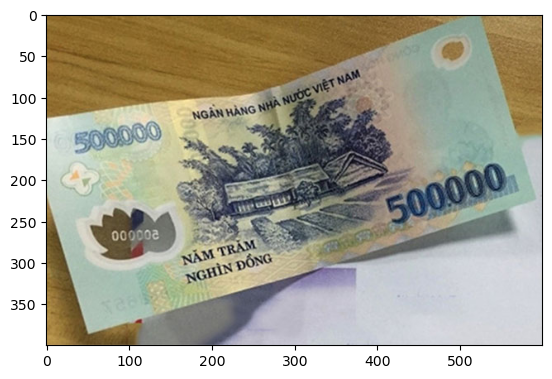

500k


In [9]:
from torchvision import transforms
import PIL.Image as Image

url = '/kaggle/input/vn-money/Money/Test/Anh6.jpg'
# Load ảnh
img = Image.open(url)


# Hiển thị ảnh
plt.imshow(img)
plt.show()
# Áp dụng transform

img_transformed = transform(img)



test = loaded_model(img_transformed.to(device))
print(class_name[torch.max(test.data,1)[1].data])

In [10]:
!zip -r money.zip /kaggle/working/runs

updating: kaggle/working/runs/ (stored 0%)
updating: kaggle/working/runs/VN_Money/ (stored 0%)
updating: kaggle/working/runs/VN_Money/Do Chinh Xac:   _Accuracy_valid/ (stored 0%)
updating: kaggle/working/runs/VN_Money/Do Chinh Xac:   _Accuracy_valid/events.out.tfevents.1683048963.ec209e707f41.23.6 (deflated 72%)
updating: kaggle/working/runs/VN_Money/Do Mat Mat:   _Loss/ (stored 0%)
updating: kaggle/working/runs/VN_Money/Do Mat Mat:   _Loss/events.out.tfevents.1683048963.ec209e707f41.23.3 (deflated 66%)
updating: kaggle/working/runs/VN_Money/events.out.tfevents.1683048951.ec209e707f41.23.0 (deflated 0%)
updating: kaggle/working/runs/VN_Money/Do Chinh Xac:   _Accuracy/ (stored 0%)
updating: kaggle/working/runs/VN_Money/Do Chinh Xac:   _Accuracy/events.out.tfevents.1683048963.ec209e707f41.23.5 (deflated 69%)
updating: kaggle/working/runs/VN_Money/events.out.tfevents.1683048956.ec209e707f41.23.1 (deflated 84%)
updating: kaggle/working/runs/VN_Money/events.out.tfevents.1683048963.ec209e707